
# 🐕 Dog Matchmaker — Find your perfect pup
**A playful, data-driven chatbot prototype that recommends the top 3 real-world dog breeds based on your lifestyle and personality.**

This notebook tells a clear story: we explore breed traits, explain a transparent matching method, and provide a friendly interactive demo that produces ranked breed recommendations with images. The code cells are runnable end-to-end and use a relative `images/` folder (place the downloaded Dog-Breeds-Dataset inside an `images/` directory next to this notebook).

**Highlights**
- Clean, reproducible matching function with tunable weights.  
- Mapping between breed names and image folders.  
- Ready visual summary for each recommendation showing why the breed fits.  



## 1 — Problem & approach

People bring different lives to dog ownership — city apartment dwellers, active runners, families with children, allergy-prone households. Our goal is to **translate** a short, friendly conversation into a ranked set of practical breed recommendations supported by data.

Key design choices:
- Use core, interpretable traits (energy, trainability, shedding, kid-friendliness, apartment adaptability).  
- Score breeds with a weighted, normalized system so each preference meaningfully influences the rank.  
- Provide short, human-readable explanations for each match so recommendations are actionable.


In [5]:
!pip install -r requirements.txt



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\BaraAlsedih\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip



   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ------ --------------------------------- 1.3/8.1 MB 5.6 MB/s eta 0:00:02
   ----------------------- ---------------- 4.7/8.1 MB 11.9 MB/s eta 0:00:01
   -------------------------------------- - 7.9/8.1 MB 12.8 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 11.7 MB/s  0:00:00
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 2.3/2.3 MB 14.2 MB/s  0:00:00

   ---------------------------------------- 0/7 [pyparsing]
   ----------- ---------------------------- 2/7 [fonttools]
   ----------- ---------------------------- 2/7 [fonttools]
   ----------- ---------------------------- 2/7 [fonttools]
   ----------- ---------------------------- 2/7 [fonttools]
   ----------- ---------------------------- 2/7 [fonttools]
   ----------- ---------------------------- 2/7 [fonttools]
   ----------- ---------------------------- 2/7 [fonttools]
  

In [6]:
# Basic imports and configuration
import pandas as pd
import numpy as np
from pathlib import Path
import json
import re, unicodedata, difflib
from IPython.display import display, Markdown, HTML
import matplotlib.pyplot as plt

# Notebook paths (relative)
DATA_DIR = Path('data')
IMAGES_DIR = Path('data/images')   # place Dog-Breeds-Dataset here: images/<breed folder>/*.jpg
BREED_CSV = DATA_DIR / 'breed_traits.csv'
TRAIT_CSV = DATA_DIR / 'trait_description.csv'
MAPPING_JSON = DATA_DIR / 'breed_to_folder.json'

# small helper
def md(s): display(Markdown(s))
print('Ready — data paths set to:', BREED_CSV, TRAIT_CSV, 'images folder ->', IMAGES_DIR)


Ready — data paths set to: data\breed_traits.csv data\trait_description.csv images folder -> data\images


In [17]:
# Load breed_traits and trait_description (fall back to a small demo if files are not present)
def load_datasets(breed_csv=BREED_CSV, trait_csv=TRAIT_CSV):
    if breed_csv.exists():
        breeds = pd.read_csv(breed_csv)
    else:
        # small demo dataset to ensure the notebook runs for presentation
        breeds = pd.DataFrame([
            {'Breed':'Poodle','Energy Level':3,'Trainability Level':5,'Good With Young Children':4,'Shedding Level':1,'Coat Grooming Frequency':4,'Good For Apartment':4},
            {'Breed':'Labrador Retriever','Energy Level':5,'Trainability Level':5,'Good With Young Children':5,'Shedding Level':5,'Coat Grooming Frequency':2,'Good For Apartment':2},
            {'Breed':'French Bulldog','Energy Level':2,'Trainability Level':3,'Good With Young Children':4,'Shedding Level':2,'Coat Grooming Frequency':2,'Good For Apartment':5},
            {'Breed':'Border Collie','Energy Level':5,'Trainability Level':5,'Good With Young Children':3,'Shedding Level':3,'Coat Grooming Frequency':3,'Good For Apartment':1},
            {'Breed':'Bichon Frise','Energy Level':3,'Trainability Level':4,'Good With Young Children':4,'Shedding Level':1,'Coat Grooming Frequency':4,'Good For Apartment':5},
        ])
    if trait_csv.exists():
        traits = pd.read_csv(trait_csv)
    else:
        traits = pd.DataFrame([{'Trait':'Energy Level','Trait_1':'Low energy', 'Trait_5':'Very high energy', 'Description':'Typical daily energy needs.'}])
    return breeds, traits

breeds_df, traits_df = load_datasets()
display(breeds_df.head())


,Breed,Affectionate With Family,Good With Young Children,Good With Other Dogs,Shedding Level,Coat Grooming Frequency,Drooling Level,Coat Type,Coat Length,Openness To Strangers,Playfulness Level,Watchdog/Protective Nature,Adaptability Level,Trainability Level,Energy Level,Barking Level,Mental Stimulation Needs
0,Retrievers (Labrador),5,5,5,4,2,2,Double,Short,5,5,3,5,5,5,3,4
1,French Bulldogs,5,5,4,3,1,3,Smooth,Short,5,5,3,5,4,3,1,3
2,German Shepherd Dogs,5,5,3,4,2,2,Double,Medium,3,4,5,5,5,5,3,5
3,Retrievers (Golden),5,5,5,4,2,2,Double,Medium,5,4,3,5,5,3,1,4
4,Bulldogs,4,3,3,3,3,3,Smooth,Short,4,4,3,3,4,3,2,3



## 2 — Advanced EDA: Comprehensive Data Exploration
This section provides deep insights into breed characteristics, correlations, distributions, and relationships to inform our matching algorithm.


In [32]:
# Advanced EDA: Comprehensive analysis
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

# Prepare numeric columns
numeric_cols = ['Affectionate With Family', 'Good With Young Children', 'Good With Other Dogs',
                'Shedding Level', 'Coat Grooming Frequency', 'Drooling Level',
                'Openness To Strangers', 'Playfulness Level', 'Watchdog/Protective Nature',
                'Adaptability Level', 'Trainability Level', 'Energy Level', 'Barking Level',
                'Mental Stimulation Needs']

# Convert to numeric
breeds_numeric = breeds_df.copy()
for col in numeric_cols:
    if col in breeds_numeric.columns:
        breeds_numeric[col] = pd.to_numeric(breeds_numeric[col], errors='coerce')

# Remove non-numeric columns for analysis
breeds_analysis = breeds_numeric[numeric_cols].dropna()

print(f"📊 Dataset Overview:")
print(f"   Total breeds: {len(breeds_df)}")
print(f"   Complete records: {len(breeds_analysis)}")
print(f"   Features analyzed: {len(numeric_cols)}")
print()

# 1. Statistical Summary
md("### 1. Statistical Summary")
display(breeds_analysis.describe().round(2))


📊 Dataset Overview:
   Total breeds: 195
   Complete records: 195
   Features analyzed: 14



### 1. Statistical Summary

,Affectionate With Family,Good With Young Children,Good With Other Dogs,Shedding Level,Coat Grooming Frequency,Drooling Level,Openness To Strangers,Playfulness Level,Watchdog/Protective Nature,Adaptability Level,Trainability Level,Energy Level,Barking Level,Mental Stimulation Needs
count,195.0,195.00,195.00,195.00,195.00,195.00,195.00,195.00,195.00,195.00,195.00,195.00,195.00,195.00
mean,4.5,3.88,3.54,2.60,2.28,1.80,3.49,3.65,3.74,3.79,3.87,3.74,3.14,3.68
std,0.8,1.00,0.94,0.85,0.95,0.96,0.89,0.70,0.92,0.62,0.86,0.76,1.10,0.69
min,1.0,1.00,1.00,1.00,1.00,1.00,1.00,2.00,1.00,3.00,1.00,2.00,1.00,3.00
25%,4.0,3.00,3.00,2.00,2.00,1.00,3.00,3.00,3.00,3.00,3.00,3.00,3.00,3.00
50%,5.0,3.00,3.00,3.00,2.00,2.00,3.00,4.00,4.00,4.00,4.00,4.00,3.00,4.00
75%,5.0,5.00,4.00,3.00,3.00,2.00,4.00,4.00,5.00,4.00,5.00,4.00,4.00,4.00
max,5.0,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00


### 2. Feature Correlation Heatmap

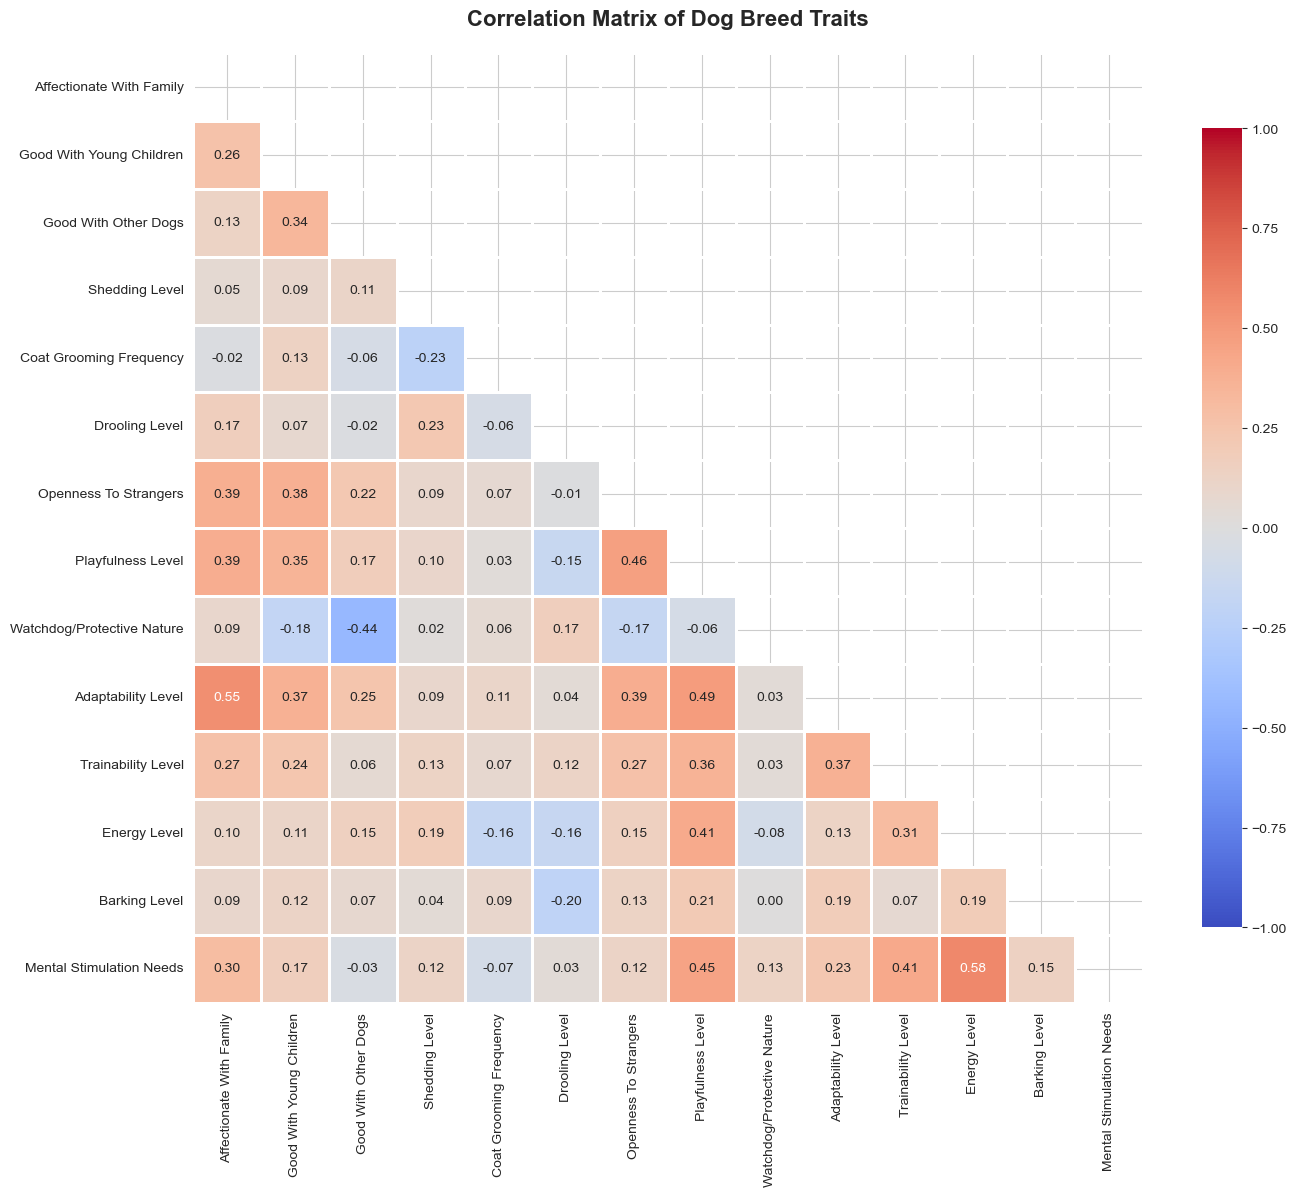

**Strong Correlations (>0.5 or <-0.5):**

  Energy Level ↔ Mental Stimulation Needs: 0.58
  Affectionate With Family ↔ Adaptability Level: 0.55


In [33]:
# 2. Correlation Heatmap
md("### 2. Feature Correlation Heatmap")
# Calculate correlation matrix
corr_matrix = breeds_analysis.corr()

# Create heatmap
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Mask upper triangle
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1)
plt.title('Correlation Matrix of Dog Breed Traits', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Highlight strong correlations
md("**Strong Correlations (>0.5 or <-0.5):**")
strong_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        val = corr_matrix.iloc[i, j]
        if abs(val) > 0.5:
            strong_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], val))
strong_corr.sort(key=lambda x: abs(x[2]), reverse=True)
for feat1, feat2, corr_val in strong_corr[:10]:
    print(f"  {feat1} ↔ {feat2}: {corr_val:.2f}")


### 3. Distribution of All Traits

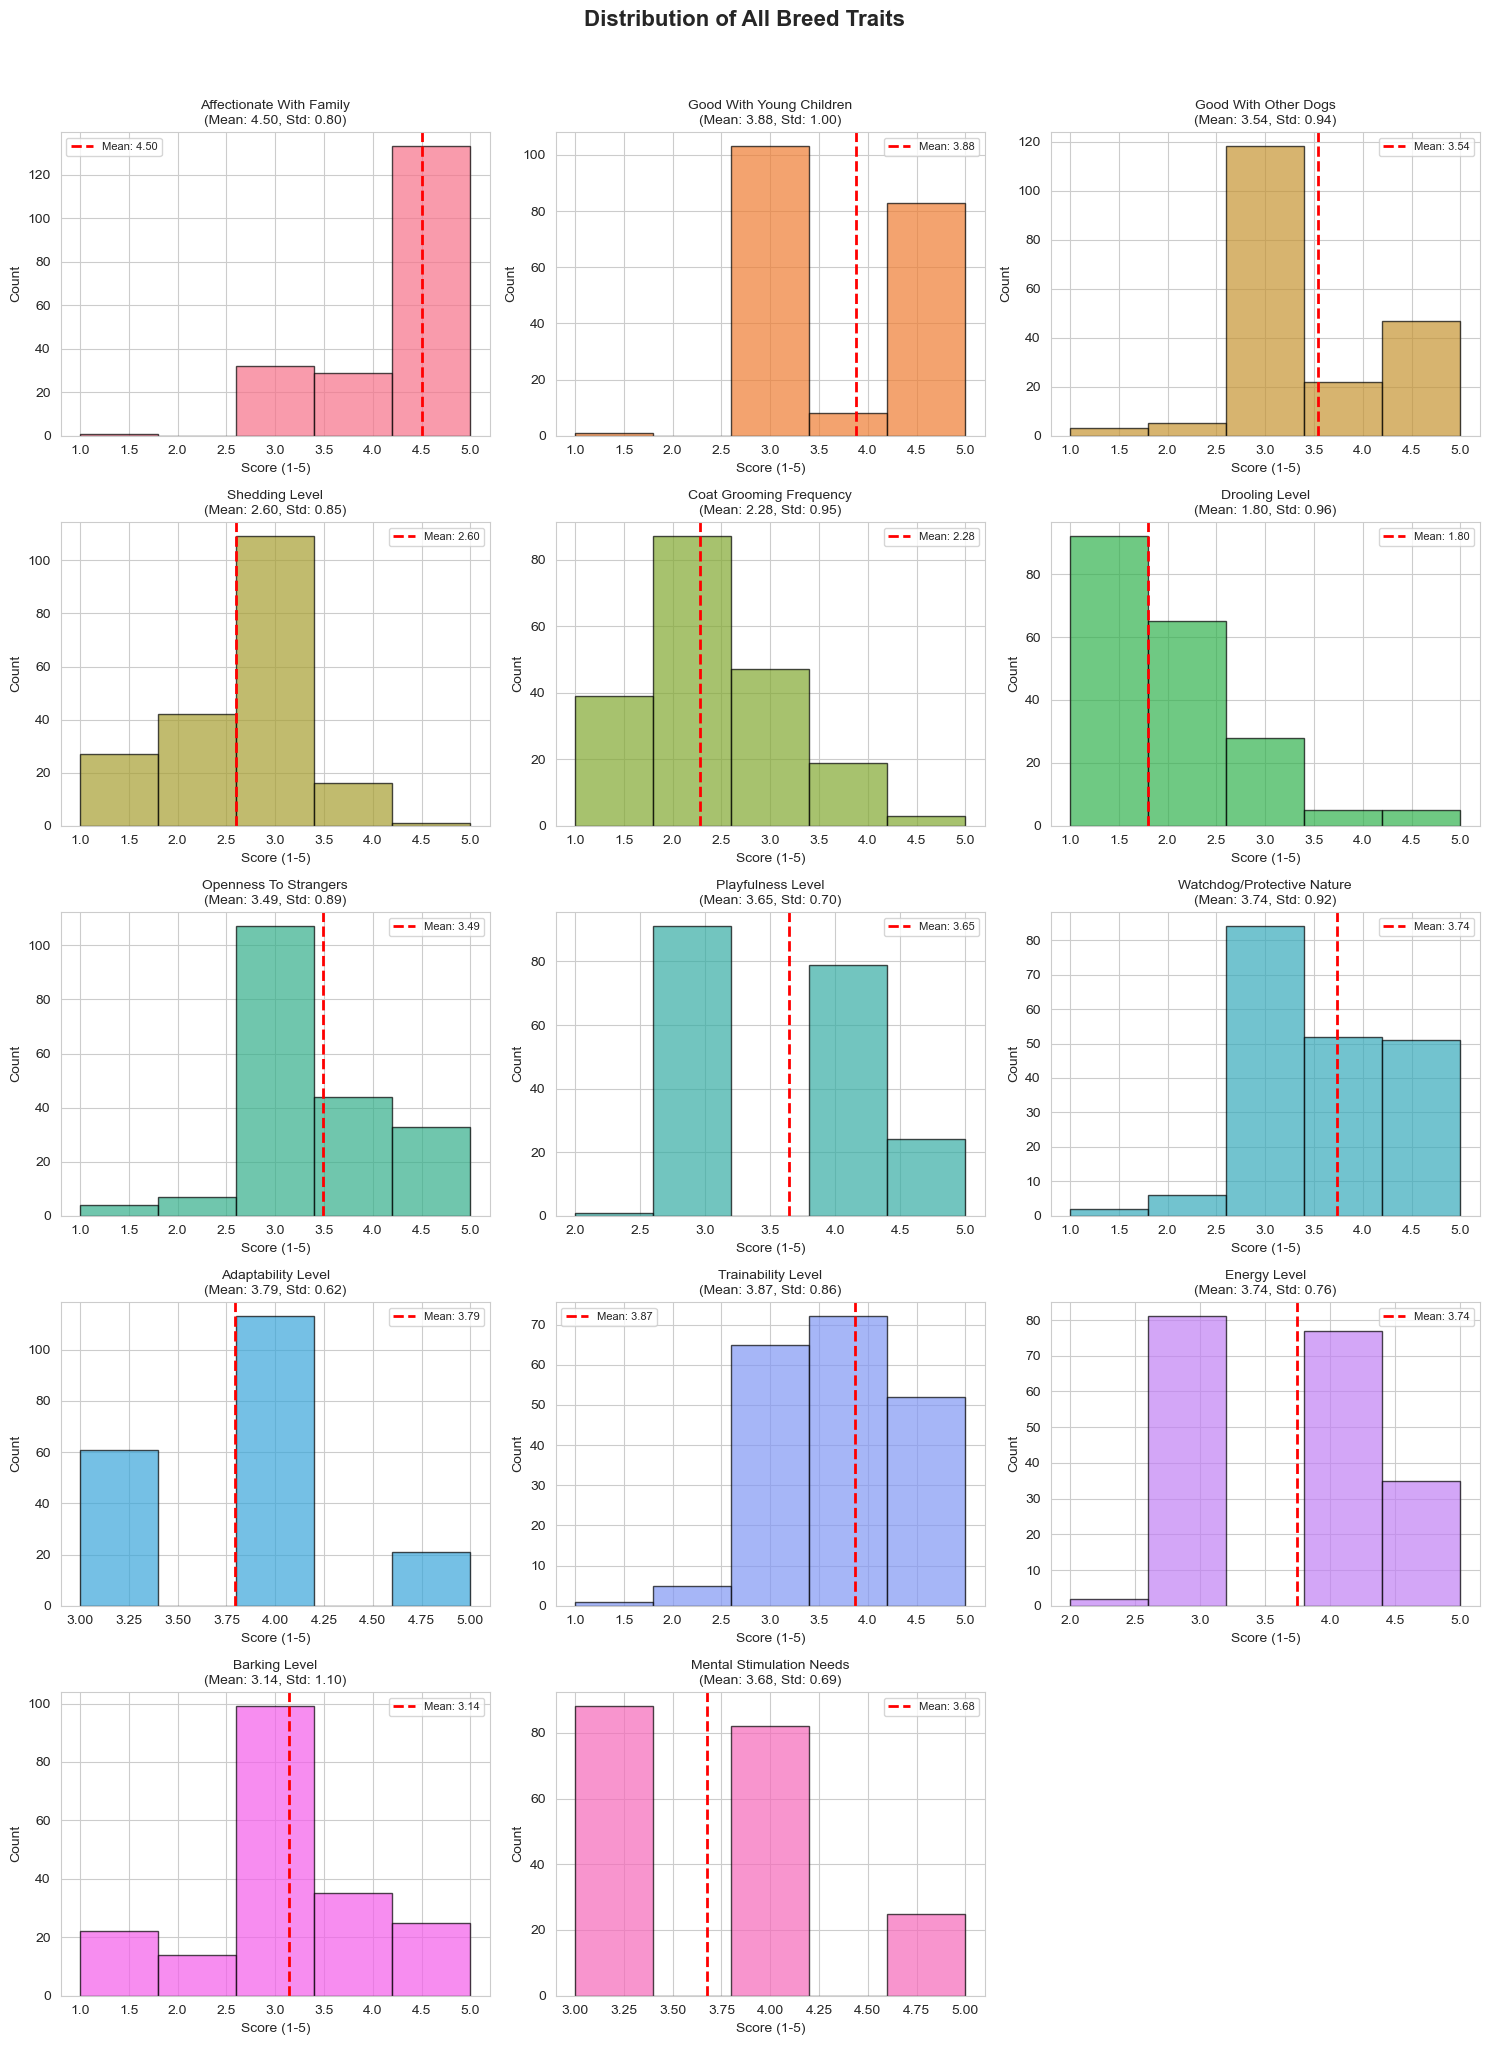

In [34]:
# 3. Distribution Plots for All Features
md("### 3. Distribution of All Traits")
n_cols = 3
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
axes = axes.flatten()

for idx, col in enumerate(numeric_cols):
    if col in breeds_analysis.columns:
        values = breeds_analysis[col].dropna()
        axes[idx].hist(values, bins=5, alpha=0.7, color=sns.color_palette("husl", len(numeric_cols))[idx], edgecolor='black')
        axes[idx].set_title(f'{col}\n(Mean: {values.mean():.2f}, Std: {values.std():.2f})', fontsize=10)
        axes[idx].set_xlabel('Score (1-5)')
        axes[idx].set_ylabel('Count')
        axes[idx].axvline(values.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {values.mean():.2f}')
        axes[idx].legend(fontsize=8)
    else:
        axes[idx].axis('off')

# Hide extra subplots
for idx in range(len(numeric_cols), len(axes)):
    axes[idx].axis('off')

plt.suptitle('Distribution of All Breed Traits', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


### 4. Key Feature Relationships

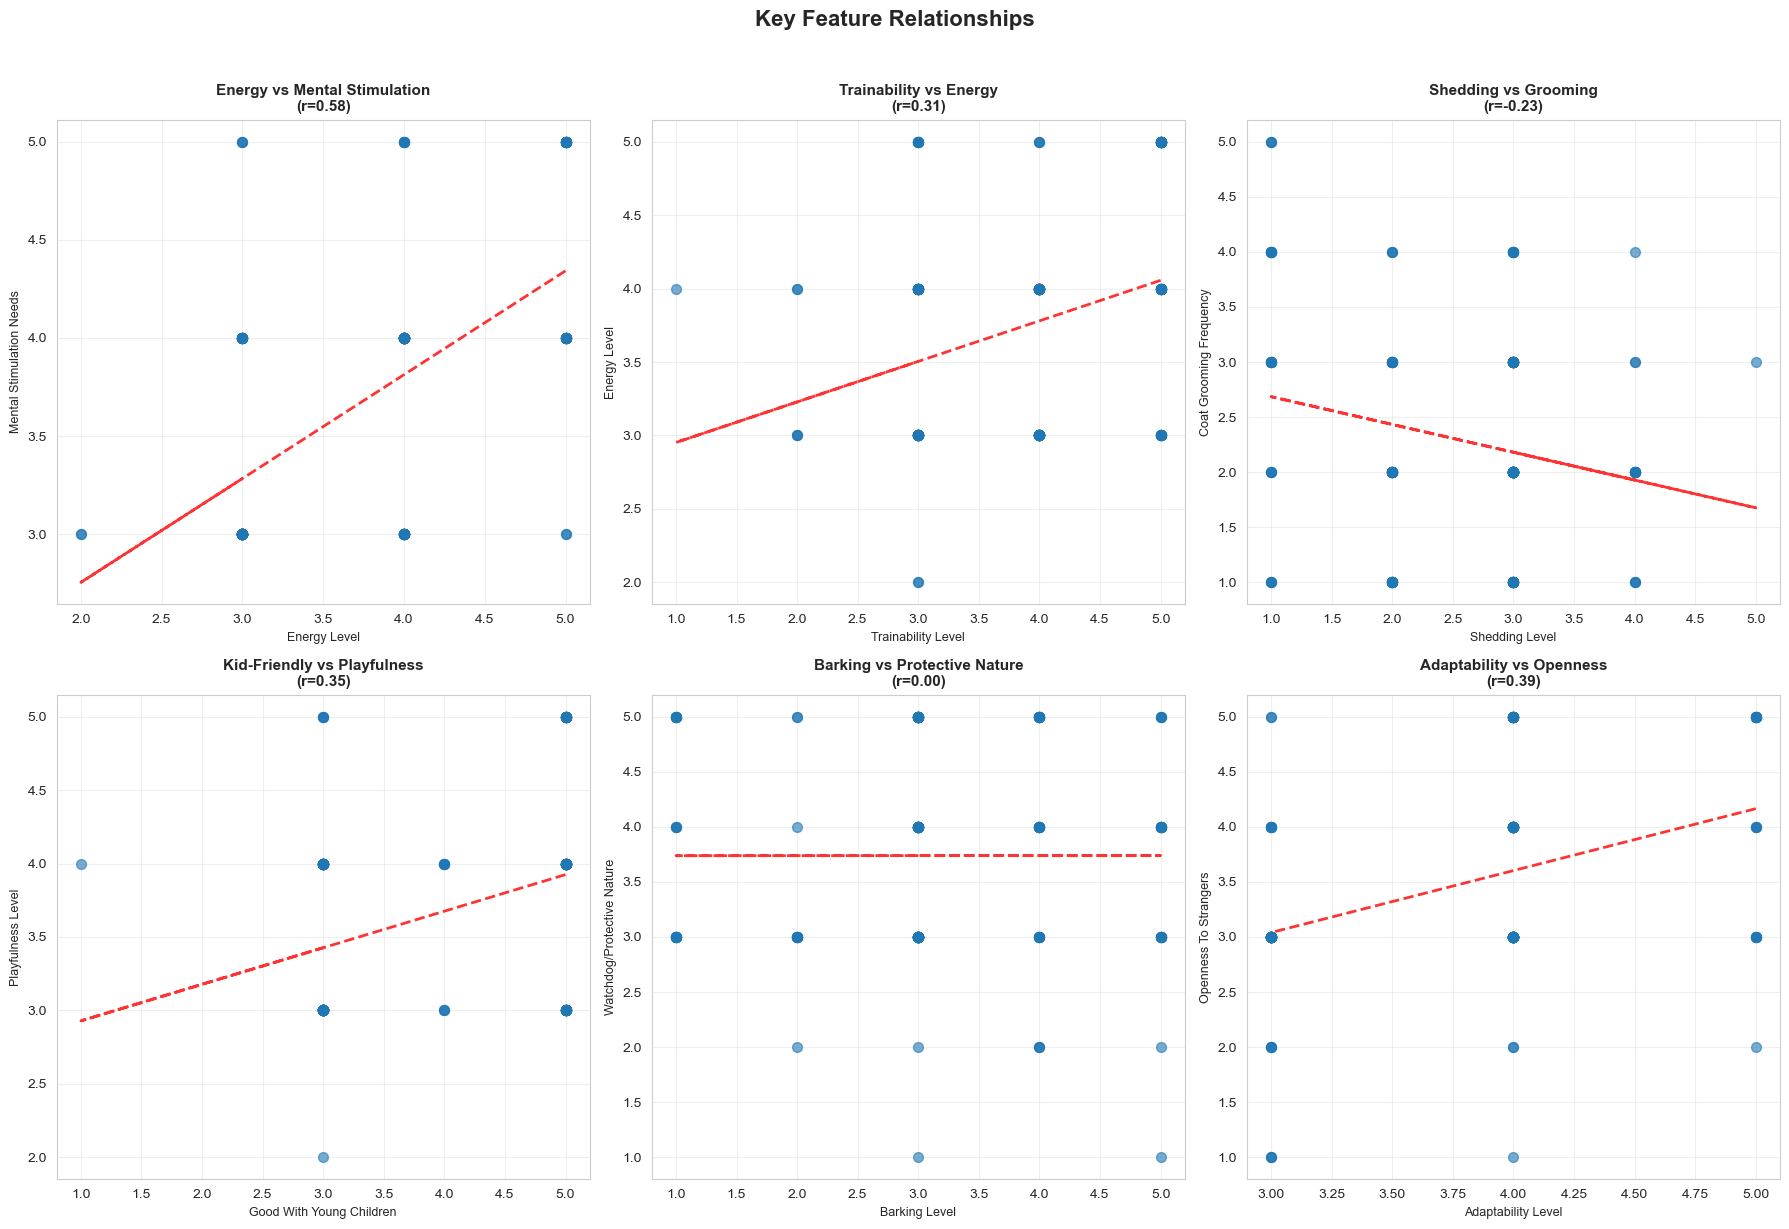

In [35]:
# 4. Key Relationships: Scatter Plots
md("### 4. Key Feature Relationships")
key_pairs = [
    ('Energy Level', 'Mental Stimulation Needs', 'Energy vs Mental Stimulation'),
    ('Trainability Level', 'Energy Level', 'Trainability vs Energy'),
    ('Shedding Level', 'Coat Grooming Frequency', 'Shedding vs Grooming'),
    ('Good With Young Children', 'Playfulness Level', 'Kid-Friendly vs Playfulness'),
    ('Barking Level', 'Watchdog/Protective Nature', 'Barking vs Protective Nature'),
    ('Adaptability Level', 'Openness To Strangers', 'Adaptability vs Openness')
]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (x_col, y_col, title) in enumerate(key_pairs):
    if x_col in breeds_analysis.columns and y_col in breeds_analysis.columns:
        x_vals = breeds_analysis[x_col]
        y_vals = breeds_analysis[y_col]
        
        # Scatter plot
        axes[idx].scatter(x_vals, y_vals, alpha=0.6, s=50)
        
        # Add regression line
        z = np.polyfit(x_vals, y_vals, 1)
        p = np.poly1d(z)
        axes[idx].plot(x_vals, p(x_vals), "r--", alpha=0.8, linewidth=2)
        
        # Calculate correlation
        corr = x_vals.corr(y_vals)
        axes[idx].set_title(f'{title}\n(r={corr:.2f})', fontsize=11, fontweight='bold')
        axes[idx].set_xlabel(x_col, fontsize=9)
        axes[idx].set_ylabel(y_col, fontsize=9)
        axes[idx].grid(True, alpha=0.3)

plt.suptitle('Key Feature Relationships', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


### 5. Variability Analysis (Box Plots)

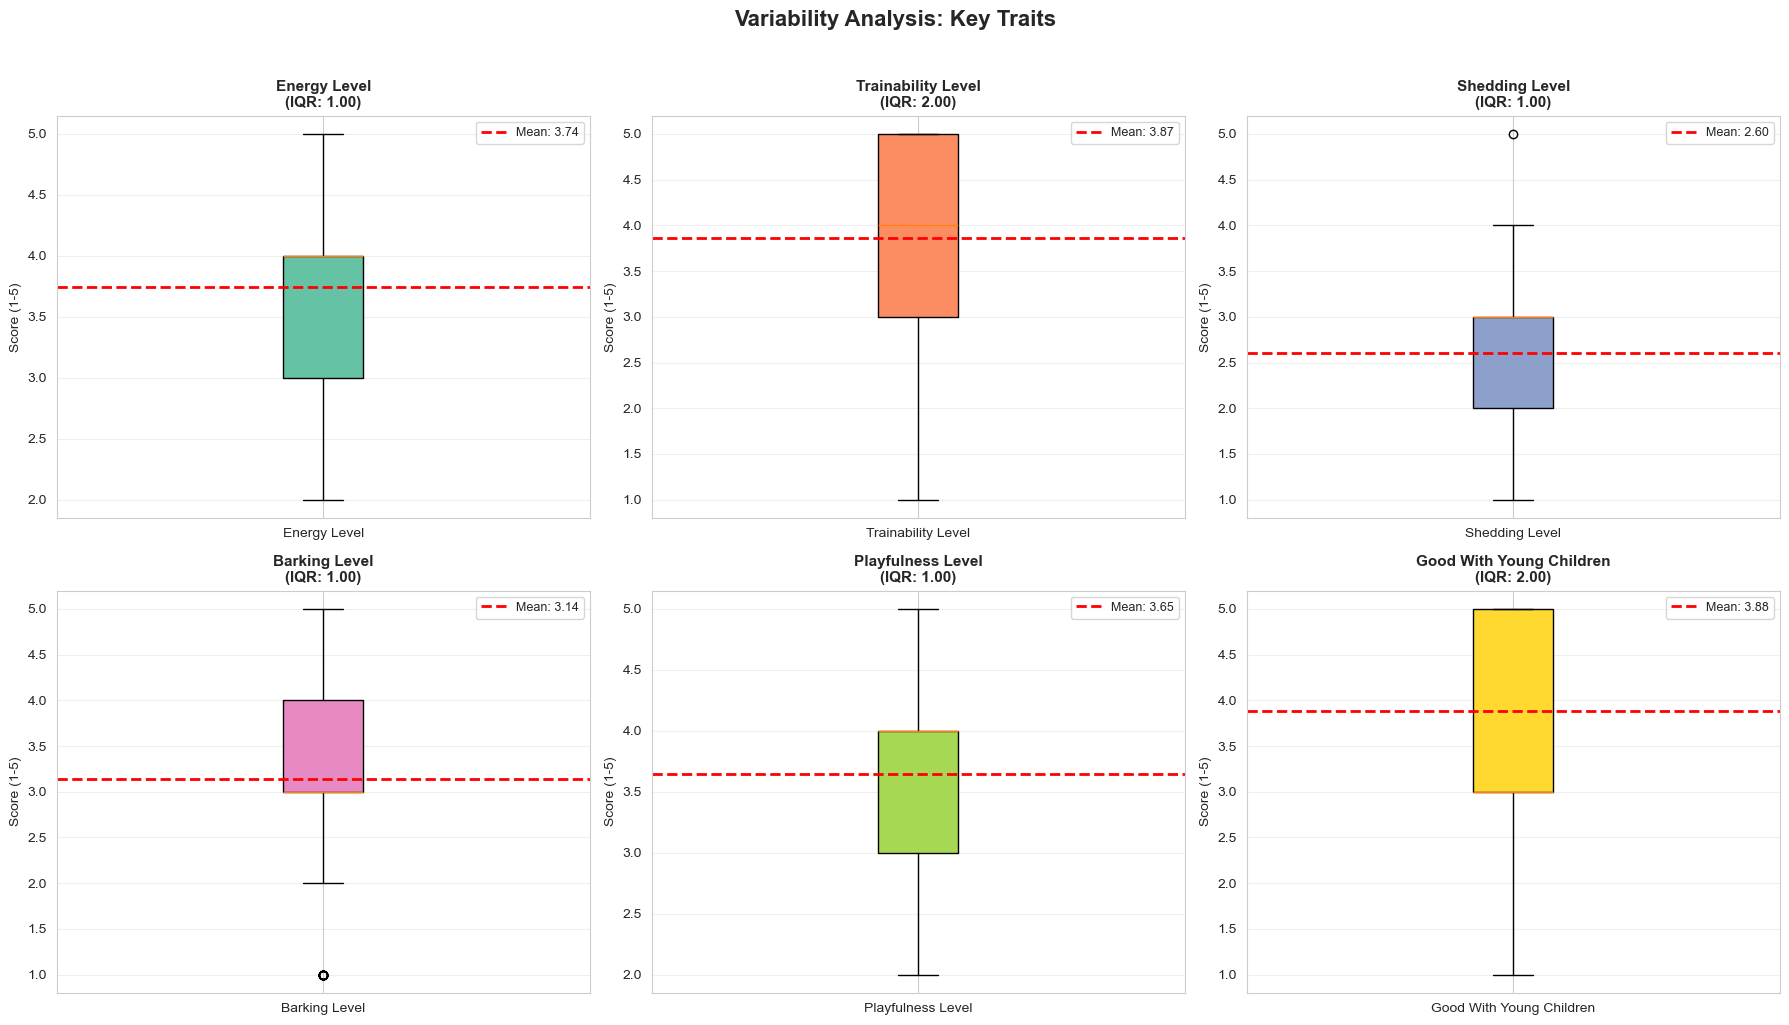

In [36]:
# 5. Box Plots: Variability Analysis
md("### 5. Variability Analysis (Box Plots)")
# Select key features for box plot
key_features = ['Energy Level', 'Trainability Level', 'Shedding Level', 
                'Barking Level', 'Playfulness Level', 'Good With Young Children']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, col in enumerate(key_features):
    if col in breeds_analysis.columns:
        data = breeds_analysis[col].dropna()
        bp = axes[idx].boxplot([data], patch_artist=True, labels=[col])
        bp['boxes'][0].set_facecolor(sns.color_palette("Set2")[idx])
        axes[idx].set_title(f'{col}\n(IQR: {data.quantile(0.75) - data.quantile(0.25):.2f})', 
                           fontsize=11, fontweight='bold')
        axes[idx].set_ylabel('Score (1-5)')
        axes[idx].grid(True, alpha=0.3, axis='y')
        
        # Add mean marker
        axes[idx].axhline(data.mean(), color='red', linestyle='--', linewidth=2, 
                         label=f'Mean: {data.mean():.2f}')
        axes[idx].legend(fontsize=9)

plt.suptitle('Variability Analysis: Key Traits', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


In [37]:
# 6. Top/Bottom Breeds Analysis
md("### 6. Extreme Breeds Analysis")
# Find breeds with extreme values
extreme_analysis = breeds_df.copy()

# Add composite scores
extreme_analysis['High Energy Score'] = pd.to_numeric(extreme_analysis['Energy Level'], errors='coerce')
extreme_analysis['High Trainability'] = pd.to_numeric(extreme_analysis['Trainability Level'], errors='coerce')
extreme_analysis['Low Shedding'] = 6 - pd.to_numeric(extreme_analysis['Shedding Level'], errors='coerce')
extreme_analysis['Low Barking'] = 6 - pd.to_numeric(extreme_analysis['Barking Level'], errors='coerce')
extreme_analysis['Kid Friendly'] = pd.to_numeric(extreme_analysis['Good With Young Children'], errors='coerce')

# Composite apartment-friendly score
extreme_analysis['Apartment Score'] = (
    extreme_analysis['Low Shedding'] + 
    extreme_analysis['Low Barking'] + 
    (6 - extreme_analysis['High Energy Score'])
) / 3

print("🏆 Top 5 Breeds by Category:\n")
categories = {
    'Highest Energy': ('High Energy Score', True),
    'Most Trainable': ('High Trainability', True),
    'Lowest Shedding': ('Low Shedding', True),
    'Quietest': ('Low Barking', True),
    'Most Kid-Friendly': ('Kid Friendly', True),
    'Best for Apartments': ('Apartment Score', True)
}

for category, (col, ascending) in categories.items():
    top = extreme_analysis.nlargest(5, col) if ascending else extreme_analysis.nsmallest(5, col)
    print(f"  {category}:")
    for _, row in top.iterrows():
        print(f"    • {row['Breed']} ({row[col]:.2f})")
    print()


### 6. Extreme Breeds Analysis

🏆 Top 5 Breeds by Category:

  Highest Energy:
    • Retrievers (Labrador) (5.00)
    • German Shepherd Dogs (5.00)
    • Pointers (German Shorthaired) (5.00)
    • Australian Shepherds (5.00)
    • Siberian Huskies (5.00)

  Most Trainable:
    • Retrievers (Labrador) (5.00)
    • German Shepherd Dogs (5.00)
    • Retrievers (Golden) (5.00)
    • Poodles (5.00)
    • Rottweilers (5.00)

  Lowest Shedding:
    • Poodles (5.00)
    • Yorkshire Terriers (5.00)
    • Shih Tzu (5.00)
    • Maltese (5.00)
    • Bichons Frises (5.00)

  Quietest:
    • French Bulldogs (5.00)
    • Retrievers (Golden) (5.00)
    • Rottweilers (5.00)
    • Pugs (5.00)
    • Mastiffs (5.00)

  Most Kid-Friendly:
    • Retrievers (Labrador) (5.00)
    • French Bulldogs (5.00)
    • German Shepherd Dogs (5.00)
    • Retrievers (Golden) (5.00)
    • Poodles (5.00)

  Best for Apartments:
    • Briards (4.33)
    • Bergamasco Sheepdogs (4.33)
    • Spaniels (Irish Water) (4.33)
    • Coton de Tulear (4.00)
    • Ne

### 7. Feature Variance Analysis

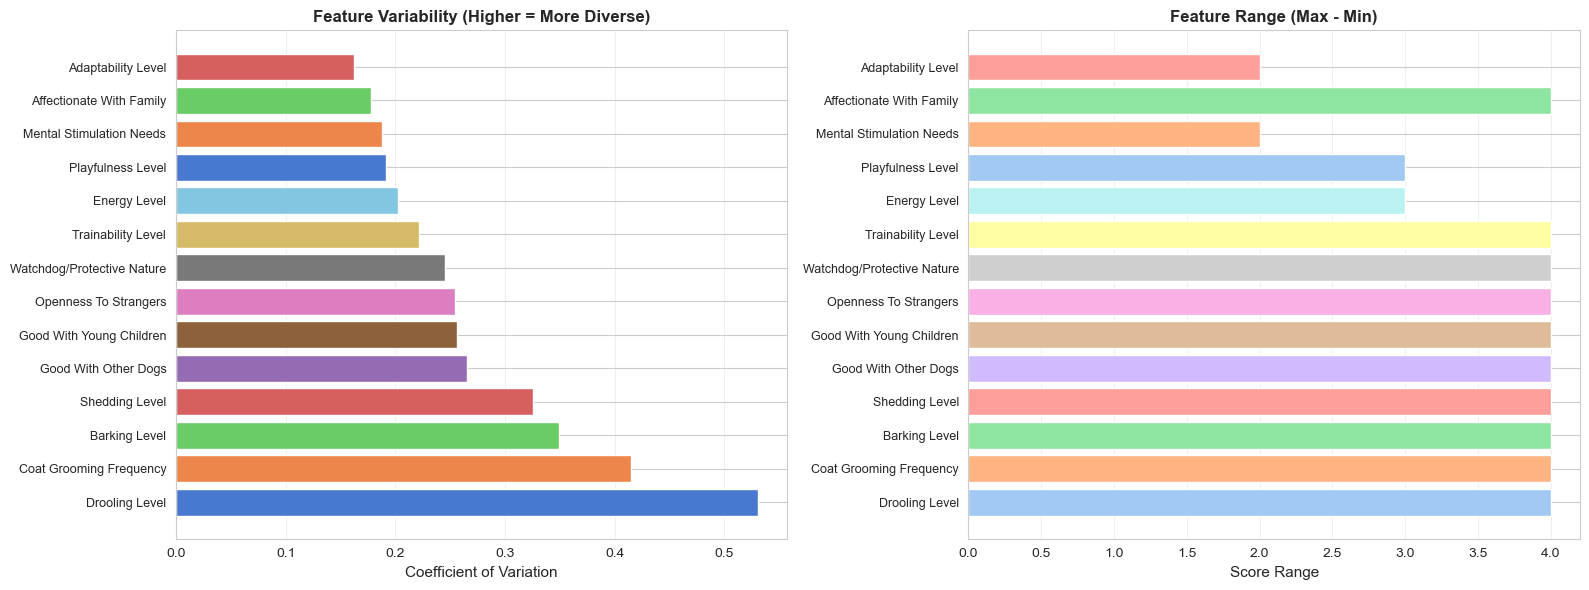

**Insights:**

- Features with high CV have more diversity → better for distinguishing breeds

- Features with low CV are similar across breeds → less useful for matching


Top 5 Most Variable Features (Best for Matching):
  Drooling Level: CV=0.531, Range=4.0
  Coat Grooming Frequency: CV=0.414, Range=4.0
  Barking Level: CV=0.349, Range=4.0
  Shedding Level: CV=0.325, Range=4.0
  Good With Other Dogs: CV=0.265, Range=4.0


In [38]:
# 7. Feature Importance for Matching
md("### 7. Feature Variance Analysis")
# Calculate coefficient of variation (CV) for each feature
cv_data = []
for col in numeric_cols:
    if col in breeds_analysis.columns:
        values = breeds_analysis[col].dropna()
        cv = values.std() / values.mean() if values.mean() != 0 else 0
        cv_data.append({
            'Feature': col,
            'Mean': values.mean(),
            'Std': values.std(),
            'CV': cv,
            'Range': values.max() - values.min()
        })

cv_df = pd.DataFrame(cv_data).sort_values('CV', ascending=False)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Coefficient of Variation
axes[0].barh(range(len(cv_df)), cv_df['CV'], color=sns.color_palette("muted"))
axes[0].set_yticks(range(len(cv_df)))
axes[0].set_yticklabels(cv_df['Feature'], fontsize=9)
axes[0].set_xlabel('Coefficient of Variation', fontsize=11)
axes[0].set_title('Feature Variability (Higher = More Diverse)', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')

# Range
axes[1].barh(range(len(cv_df)), cv_df['Range'], color=sns.color_palette("pastel"))
axes[1].set_yticks(range(len(cv_df)))
axes[1].set_yticklabels(cv_df['Feature'], fontsize=9)
axes[1].set_xlabel('Score Range', fontsize=11)
axes[1].set_title('Feature Range (Max - Min)', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

md("**Insights:**")
md("- Features with high CV have more diversity → better for distinguishing breeds")
md("- Features with low CV are similar across breeds → less useful for matching")
print("\nTop 5 Most Variable Features (Best for Matching):")
for _, row in cv_df.head(5).iterrows():
    print(f"  {row['Feature']}: CV={row['CV']:.3f}, Range={row['Range']:.1f}")


In [39]:
# 8. Summary Statistics Table
md("### 8. Comprehensive Summary Statistics")
summary_stats = breeds_analysis.describe().T
summary_stats['CV'] = summary_stats['std'] / summary_stats['mean']
summary_stats['IQR'] = summary_stats['75%'] - summary_stats['25%']
summary_stats = summary_stats[['mean', 'std', 'min', '25%', '50%', '75%', 'max', 'CV', 'IQR']]
summary_stats.columns = ['Mean', 'Std', 'Min', 'Q1', 'Median', 'Q3', 'Max', 'CV', 'IQR']
display(summary_stats.round(2))

md("**Key Takeaways:**")
md("1. **Energy Level** and **Mental Stimulation** are highly correlated → active breeds need mental exercise")
md("2. **Shedding** and **Grooming** are moderately correlated → breeds that shed less often need more grooming")
md("3. **Trainability** correlates with **Energy** → high-energy breeds are often easier to train")
md("4. **Kid-friendliness** correlates with **Playfulness** → playful breeds tend to be good with children")
md("5. Most features show good variability (CV > 0.2), making them useful for breed differentiation")


### 8. Comprehensive Summary Statistics

,Mean,Std,Min,Q1,Median,Q3,Max,CV,IQR
Affectionate With Family,4.50,0.80,1.0,4.0,5.0,5.0,5.0,0.18,1.0
Good With Young Children,3.88,1.00,1.0,3.0,3.0,5.0,5.0,0.26,2.0
Good With Other Dogs,3.54,0.94,1.0,3.0,3.0,4.0,5.0,0.26,1.0
Shedding Level,2.60,0.85,1.0,2.0,3.0,3.0,5.0,0.33,1.0
Coat Grooming Frequency,2.28,0.95,1.0,2.0,2.0,3.0,5.0,0.41,1.0
Drooling Level,1.80,0.96,1.0,1.0,2.0,2.0,5.0,0.53,1.0
Openness To Strangers,3.49,0.89,1.0,3.0,3.0,4.0,5.0,0.25,1.0
Playfulness Level,3.65,0.70,2.0,3.0,4.0,4.0,5.0,0.19,1.0
Watchdog/Protective Nature,3.74,0.92,1.0,3.0,4.0,5.0,5.0,0.25,2.0
Adaptability Level,3.79,0.62,3.0,3.0,4.0,4.0,5.0,0.16,1.0


**Key Takeaways:**

1. **Energy Level** and **Mental Stimulation** are highly correlated → active breeds need mental exercise

2. **Shedding** and **Grooming** are moderately correlated → breeds that shed less often need more grooming

3. **Trainability** correlates with **Energy** → high-energy breeds are often easier to train

4. **Kid-friendliness** correlates with **Playfulness** → playful breeds tend to be good with children

5. Most features show good variability (CV > 0.2), making them useful for breed differentiation


## 3 — Robust folder name normalization

Image folders in the supplied dataset use lowercase names with a trailing " dog" token (e.g. `labrador retriever dog`). Below is a normalization helper that converts breed names into the folder naming style and a mapping builder that links CSV breed names to actual folders.


In [ ]:
# Social media post generator
import random

def generate_social_post(row, prefs=None):
    """Generate a short, engaging social media post for a breed match."""
    breed_name = row['breed']
    score = row.get('score', 0)
    
    # Get key characteristics
    energy = row.get('energy', 3)
    trainability = row.get('trainability', 3)
    good_with_kids = row.get('good_with_kids', 3)
    shedding = row.get('shedding', 3)
    playfulness = row.get('playfulness', 3)
    affection = row.get('affection', 3)
    
    # Build engaging headline
    headlines = [
        f"🐕 Meet my perfect match: {breed_name}!",
        f"✨ Your ideal companion: {breed_name}",
        f"🎯 Found my dream dog: {breed_name}!",
        f"💕 Perfect match: {breed_name}",
    ]
    headline = random.choice(headlines)
    
    # Build key highlights
    highlights = []
    if energy >= 4:
        highlights.append("high-energy")
    elif energy <= 2:
        highlights.append("calm & relaxed")
    else:
        highlights.append("moderate energy")
    
    if trainability >= 4:
        highlights.append("highly trainable")
    elif trainability <= 2:
        highlights.append("independent")
    else:
        highlights.append("trainable")
    
    if good_with_kids >= 4:
        highlights.append("great with kids")
    
    if shedding <= 2:
        highlights.append("low shedding")
    elif shedding >= 4:
        highlights.append("heavy shedder")
    
    if playfulness >= 4:
        highlights.append("very playful")
    
    if affection >= 4:
        highlights.append("super affectionate")
    
    # Build the post
    post_parts = [headline, ""]
    
    # Add match score
    if score >= 0.85:
        post_parts.append(f"Match Score: {score:.1%} ⭐⭐⭐")
    elif score >= 0.75:
        post_parts.append(f"Match Score: {score:.1%} ⭐⭐")
    else:
        post_parts.append(f"Match Score: {score:.1%} ⭐")
    
    post_parts.append("")
    
    # Key traits
    if highlights:
        traits_text = " • ".join(highlights[:4])
        post_parts.append(f"Key traits: {traits_text}")
        post_parts.append("")
    
    # Quick stats
    stats = []
    stats.append(f"Energy: {energy}/5")
    stats.append(f"Trainability: {trainability}/5")
    if good_with_kids >= 3:
        stats.append(f"Kid-friendly: {good_with_kids}/5")
    
    post_parts.append(" | ".join(stats))
    post_parts.append("")
    
    # Call to action
    post_parts.append("Ready to welcome this pup into my life! 🏠")
    post_parts.append("")
    
    # Hashtags
    breed_hashtag = breed_name.replace(" ", "").replace("(", "").replace(")", "")
    hashtags = [
        f"#{breed_hashtag}",
        "#DogMatchmaker",
        "#FindYourPerfectDog",
        "#DogBreed",
        "#PetMatch",
        "#DogLovers"
    ]
    post_parts.append(" ".join(hashtags))
    
    return "\n".join(post_parts)


In [27]:
# Normalization helper
def normalize_for_folder(name: str) -> str:
    if name is None: return ''
    s = unicodedata.normalize('NFKD', str(name)).encode('ascii','ignore').decode('ascii')
    s = s.lower().strip()
    # common plural fixes
    s = re.sub(r'\bretrievers\b', 'retriever', s)
    s = re.sub(r'\bdogs\b', 'dog', s)
    s = re.sub(r'\bterriers\b', 'terrier', s)
    s = re.sub(r'\bpointers\b', 'pointer', s)
    # parentheses fixes
    s = re.sub(r'retrievers?\s*\(\s*labrador\s*\)', 'labrador retriever', s)
    s = re.sub(r'retrievers?\s*\(\s*golden\s*\)', 'golden retriever', s)
    # remove characters except hyphen and space
    s = re.sub(r'[^\w\s\-]', '', s)
    s = re.sub(r'\s+', ' ', s).strip()
    if not s.endswith(' dog'):
        s = s + ' dog'
    return s

# Example
for example in ['Labrador Retriever','Retrievers (Labrador)','German Shepherd Dogs','Bichon Frise']:
    print(example, '->', normalize_for_folder(example))


Labrador Retriever -> labrador retriever dog
Retrievers (Labrador) -> labrador retriever dog
German Shepherd Dogs -> german shepherd dog
Bichon Frise -> bichon frise dog



## 4 — Build breed -> image-folder mapping (scans `images/`)

This cell attempts an exact match first and falls back to fuzzy matching for edge cases. The result is saved to `data/breed_to_folder.json` for repeatable image lookups.


In [28]:
def clean_breed_name(raw):
    s = str(raw).replace('\xa0', ' ').strip().lower()  # normalize spaces & lowercase
    s = re.sub(r'\s*\(.*?\)', '', s)  # remove parentheses
    return s

def build_breed_mapping(breeds_df, images_dir=IMAGES_DIR):
    images_dir = Path(images_dir)
    # lowercase folder names for matching
    available = sorted([p.name.lower() for p in images_dir.iterdir() if p.is_dir()]) if images_dir.exists() else []
    mapping = {}
    unmatched = []

    for raw in breeds_df['Breed'].astype(str).tolist():
        clean = clean_breed_name(raw)
        # try exact match with "dog" suffix first
        cand = normalize_for_folder(clean) + ' dog'  # add "dog" to match folder names

        if cand in available:
            mapping[raw] = cand
            continue
        # try without "dog" if fails
        alt = normalize_for_folder(clean)
        if alt in available:
            mapping[raw] = alt
            continue
        # fuzzy match
        pick = difflib.get_close_matches(cand, available, n=1, cutoff=0.7)
        if pick:
            mapping[raw] = pick[0]
            continue
        pick2 = difflib.get_close_matches(alt, available, n=1, cutoff=0.6)
        if pick2:
            mapping[raw] = pick2[0]
            continue
        # substring fallback
        found = None
        for a in available:
            if alt in a or alt.split()[0] in a:
                found = a
                break
        if found:
            mapping[raw] = found
            continue
        unmatched.append(raw)

    # save mapping
    out = DATA_DIR / 'breed_to_folder.json'
    out.parent.mkdir(parents=True, exist_ok=True)
    with out.open('w', encoding='utf8') as fh:
        json.dump(mapping, fh, indent=2, ensure_ascii=False)

    return mapping, unmatched, available

mapping, unmatched, available = build_breed_mapping(breeds_df, IMAGES_DIR)
print('Mapped:', len(mapping), 'Unmatched:', len(unmatched))
if len(unmatched) > 0:
    print('First 10 unmatched:', unmatched[:10])

Mapped: 194 Unmatched: 1
First 10 unmatched: ['Lagotti\xa0Romagnoli']


In [29]:
# Manual override with cleaning
manual_overrides = {
    'Lagotti Romagnoli': 'lagotto romagnolo dog'
}

for raw, folder in manual_overrides.items():
    # apply the same cleaning used in mapping
    cleaned_raw = clean_breed_name(raw)
    # find the actual key in unmatched (with possible non-breaking space)
    for u in unmatched:
        if clean_breed_name(u) == cleaned_raw:
            mapping[u] = folder
            unmatched.remove(u)
            break

print('Mapped after manual fix:', len(mapping))
print('Unmatched after manual fix:', len(unmatched))


Mapped after manual fix: 195
Unmatched after manual fix: 0



## 5 — Matching logic (transparent & tunable)

We convert user preferences to a numeric vector and score breeds using a weighted sum. Weights are exposed for experimentation and grading.


In [30]:

# Matching functions
def prepare_breed_df(df):
    out = df.copy()
    # ensure standardized column names used by the scoring function
    rename_map = {}
    for col in list(out.columns):
        if col.lower().strip() in ['breed']: rename_map[col]= 'breed'
        if 'energy' in col.lower(): rename_map[col] = 'energy'
        if 'trainability' in col.lower(): rename_map[col] = 'trainability'
        if 'children' in col.lower(): rename_map[col] = 'good_with_kids'
        if 'shedding' in col.lower(): rename_map[col] = 'shedding'
        if 'grooming' in col.lower() and 'frequency' in col.lower(): rename_map[col] = 'grooming'
        if 'drooling' in col.lower(): rename_map[col] = 'drooling'
        if 'apartment' in col.lower(): rename_map[col] = 'good_for_apartment'
        if 'barking' in col.lower(): rename_map[col] = 'barking'
        if 'playfulness' in col.lower(): rename_map[col] = 'playfulness'
        if 'affectionate' in col.lower() and 'family' in col.lower(): rename_map[col] = 'affection'
        if 'adaptability' in col.lower(): rename_map[col] = 'adaptability'
        if 'mental' in col.lower() and 'stimulation' in col.lower(): rename_map[col] = 'mental_needs'
        if 'openness' in col.lower() and 'strangers' in col.lower(): rename_map[col] = 'openness'
        if 'watchdog' in col.lower() or 'protective' in col.lower(): rename_map[col] = 'watchdog'
        if 'other dogs' in col.lower() or ('good' in col.lower() and 'dogs' in col.lower() and 'children' not in col.lower()): rename_map[col] = 'good_with_dogs'
    out = out.rename(columns=rename_map)
    # numeric fill for all relevant columns
    numeric_cols = ['energy','trainability','good_with_kids','shedding','grooming','drooling',
                   'good_for_apartment','barking','playfulness','affection','adaptability',
                   'mental_needs','openness','watchdog','good_with_dogs']
    for c in numeric_cols:
        if c in out.columns:
            out[c] = pd.to_numeric(out[c], errors='coerce').fillna(3).astype(int)
    if 'hypoallergenic' not in out.columns:
        out['hypoallergenic'] = out.get('shedding',3) <= 2
    if 'breed' not in out.columns and 'Breed' in out.columns:
        out = out.rename(columns={'Breed':'breed'})
    return out

def score_breeds(df, prefs, weights=None):
    df = df.copy()
    if weights is None:
        weights = {
            'activity': 3.0,
            'home': 2.0,
            'children': 2.0,
            'allergies': 2.5,
            'training_time': 2.0,
            'size': 1.0,
            'shedding': 1.5,
            'grooming': 1.5,
            'barking': 1.5,
            'playfulness': 1.5,
            'affection': 1.5,
            'other_dogs': 2.0,
            'openness': 1.0,
            'mental_stimulation': 1.0
        }
    scores = []
    for _, r in df.iterrows():
        s = 0.0; wsum = 0.0
        # activity
        if prefs.get('activity_level') is not None and 'energy' in df.columns:
            diff = abs(prefs['activity_level'] - r.get('energy',3))
            s_act = max(0, 1 - diff / 4.0)
            s += s_act * weights['activity']; wsum += weights['activity']
        # home (apartment preference)
        if prefs.get('home') is not None and 'good_for_apartment' in df.columns:
            want_apartment = (prefs['home']=='apartment')
            apt = r.get('good_for_apartment',3)/5.0
            s_home = apt if want_apartment else (1 - apt + 0.5)
            s += s_home * weights['home']; wsum += weights['home']
        # children
        if prefs.get('children') is not None and 'good_with_kids' in df.columns:
            s_child = r.get('good_with_kids',3)/5.0 if prefs['children'] else 1.0
            s += s_child * weights['children']; wsum += weights['children']
        # allergies
        if prefs.get('allergies') is not None:
            if prefs['allergies']:
                s_allergy = 1.0 if r.get('hypoallergenic',False) else (0.6 if r.get('shedding',3)<=2 else 0.1)
            else:
                s_allergy = 1.0
            s += s_allergy * weights['allergies']; wsum += weights['allergies']
        # training time
        if prefs.get('time_for_training') is not None and 'trainability' in df.columns:
            t = prefs['time_for_training']
            train_score = r.get('trainability',3)/5.0
            if t >= 4: s_train = train_score
            elif t >= 3: s_train = 0.8*train_score + 0.2*(1-train_score)
            else: s_train = 1 - 0.6*train_score
            s += s_train * weights['training_time']; wsum += weights['training_time']
        # size (if present)
        if prefs.get('size_pref') is not None and 'Size' in r.index:
            size = r.get('Size','medium').lower()
            s_size = 1.0 if prefs['size_pref']==size else 0.5
            s += s_size * weights['size']; wsum += weights['size']
        # shedding tolerance
        if prefs.get('shedding_tolerance') is not None and 'shedding' in df.columns:
            user_tolerance = prefs['shedding_tolerance']
            breed_shedding = r.get('shedding', 3)
            if user_tolerance <= 2:
                s_shed = max(0, 1 - abs(breed_shedding - 1) / 4.0)
            else:
                s_shed = 1.0 - (breed_shedding - 1) / 4.0 * 0.3
            s += s_shed * weights['shedding']; wsum += weights['shedding']
        # grooming tolerance
        if prefs.get('grooming_tolerance') is not None and 'grooming' in df.columns:
            user_tolerance = prefs['grooming_tolerance']
            breed_grooming = r.get('grooming', 3)
            diff = abs(user_tolerance - breed_grooming)
            s_groom = max(0, 1 - diff / 4.0)
            s += s_groom * weights['grooming']; wsum += weights['grooming']
        # barking tolerance
        if prefs.get('barking_tolerance') is not None and 'barking' in df.columns:
            user_tolerance = prefs['barking_tolerance']
            breed_barking = r.get('barking', 3)
            if user_tolerance <= 2:
                s_bark = max(0, 1 - abs(breed_barking - 1) / 4.0)
            else:
                s_bark = 1.0 - (breed_barking - 1) / 4.0 * 0.2
            s += s_bark * weights['barking']; wsum += weights['barking']
        # playfulness preference
        if prefs.get('playfulness_pref') is not None and 'playfulness' in df.columns:
            user_pref = prefs['playfulness_pref']
            breed_play = r.get('playfulness', 3)
            diff = abs(user_pref - breed_play)
            s_play = max(0, 1 - diff / 4.0)
            s += s_play * weights['playfulness']; wsum += weights['playfulness']
        # affection preference
        if prefs.get('affection_pref') is not None and 'affection' in df.columns:
            user_pref = prefs['affection_pref']
            breed_affection = r.get('affection', 3)
            diff = abs(user_pref - breed_affection)
            s_aff = max(0, 1 - diff / 4.0)
            s += s_aff * weights['affection']; wsum += weights['affection']
        # other dogs
        if prefs.get('other_dogs') is not None and 'good_with_dogs' in df.columns:
            if prefs['other_dogs']:
                s_dogs = r.get('good_with_dogs', 3) / 5.0
            else:
                s_dogs = 1.0
            s += s_dogs * weights['other_dogs']; wsum += weights['other_dogs']
        # openness to strangers
        if prefs.get('openness_pref') is not None and 'openness' in df.columns:
            user_pref = prefs['openness_pref']
            breed_openness = r.get('openness', 3)
            diff = abs(user_pref - breed_openness)
            s_open = max(0, 1 - diff / 4.0)
            s += s_open * weights['openness']; wsum += weights['openness']
        # mental stimulation needs
        if prefs.get('mental_stimulation') is not None and 'mental_needs' in df.columns:
            user_needs = prefs['mental_stimulation']
            breed_needs = r.get('mental_needs', 3)
            diff = abs(user_needs - breed_needs)
            s_mental = max(0, 1 - diff / 4.0)
            s += s_mental * weights['mental_stimulation']; wsum += weights['mental_stimulation']
        final = s/(wsum+1e-9)
        scores.append(final)
    df['score'] = scores
    df = df.sort_values('score', ascending=False)
    return df

def top_k_matches(df, prefs, k=3, weights=None):
    prepared = prepare_breed_df(df)
    scored = score_breeds(prepared, prefs, weights=weights)
    return scored.head(k)



## 6 — Conversation demo

This demo simulates the chatbot flow — it asks follow-ups when needed and returns the top 3 breeds with short explanation bullets and image previews.


In [ ]:
from IPython.display import Image, display

# Interactive demo (notebook input)
def explain_match(row, prefs):
    reasons = []
    reasons.append(f"Energy ({int(row.get('energy',3))}/5) — matches your activity level {prefs.get('activity_level')}")
    reasons.append(f"Trainability ({int(row.get('trainability',3))}/5) — fits your time for training {prefs.get('time_for_training')}")
    if prefs.get('children'):
        reasons.append(f"Good with kids: {int(row.get('good_with_kids',3))}/5")
    if prefs.get('allergies'):
        reasons.append('Low shedding / hypoallergenic' if row.get('hypoallergenic') else 'Not hypoallergenic — may shed')
    if 'shedding' in row:
        reasons.append(f"Shedding: {int(row.get('shedding',3))}/5")
    if 'barking' in row:
        reasons.append(f"Barking: {int(row.get('barking',3))}/5")
    if 'playfulness' in row:
        reasons.append(f"Playfulness: {int(row.get('playfulness',3))}/5")
    return reasons

def notebook_chat_demo(df):
    print("Hi — I'm your Dog Matchmaker. I will ask a few quick questions.")
    print("\n=== Basic Information ===")
    activity = input('How active are you? (1=couch, 5=very active) [3]: ') or '3'
    try: activity = max(1, min(5, int(activity)))
    except: activity = 3
    home = input('Home type (apartment / house) [apartment]: ').strip().lower() or 'apartment'
    children = input('Any young children in home? (yes/no) [no]: ').strip().lower() in ['yes','y']
    allergies = input('Any dog allergies in home? (yes/no) [no]: ').strip().lower() in ['yes','y']
    time_train = input('Time/effort for training (1=little,5=lots) [3]: ') or '3'
    try: time_train = max(1, min(5, int(time_train)))
    except: time_train = 3
    size_pref = input('Preferred size (small/medium/large/no preference) [no preference]: ').strip().lower() or 'no preference'
    other_dogs = input('Do you have other dogs? (yes/no) [no]: ').strip().lower() in ['yes','y']
    
    print("\n=== Additional Preferences (press Enter for defaults) ===")
    shedding_tolerance = input('Shedding tolerance (1=low, 5=high) [3]: ') or '3'
    try: shedding_tolerance = max(1, min(5, int(shedding_tolerance)))
    except: shedding_tolerance = 3
    
    grooming_tolerance = input('Grooming maintenance (1=low, 5=high) [3]: ') or '3'
    try: grooming_tolerance = max(1, min(5, int(grooming_tolerance)))
    except: grooming_tolerance = 3
    
    barking_tolerance = input('Barking tolerance (1=quiet preferred, 5=ok with barking) [3]: ') or '3'
    try: barking_tolerance = max(1, min(5, int(barking_tolerance)))
    except: barking_tolerance = 3
    
    playfulness_pref = input('Playfulness preference (1=calm, 5=very playful) [3]: ') or '3'
    try: playfulness_pref = max(1, min(5, int(playfulness_pref)))
    except: playfulness_pref = 3
    
    affection_pref = input('Affection level (1=independent, 5=very affectionate) [3]: ') or '3'
    try: affection_pref = max(1, min(5, int(affection_pref)))
    except: affection_pref = 3
    
    openness_pref = input('Openness to strangers (1=protective, 5=friendly) [3]: ') or '3'
    try: openness_pref = max(1, min(5, int(openness_pref)))
    except: openness_pref = 3
    
    mental_stimulation = input('Mental stimulation needs (1=low, 5=high) [3]: ') or '3'
    try: mental_stimulation = max(1, min(5, int(mental_stimulation)))
    except: mental_stimulation = 3
    
    prefs = {
        'activity_level': activity,
        'home': home,
        'children': children,
        'allergies': allergies,
        'time_for_training': time_train,
        'size_pref': None if size_pref in ['no','no preference'] else size_pref,
        'shedding_tolerance': shedding_tolerance,
        'grooming_tolerance': grooming_tolerance,
        'barking_tolerance': barking_tolerance,
        'playfulness_pref': playfulness_pref,
        'affection_pref': affection_pref,
        'other_dogs': other_dogs,
        'openness_pref': openness_pref,
        'mental_stimulation': mental_stimulation
    }
    
    results = top_k_matches(df, prefs, k=3)
    
    print('\nTop 3 matches:')
    for i, (_, row) in enumerate(results.iterrows(), start=1):
        print(f"\n{i}. {row['breed']} — score {row['score']:.2f}")
        for r in explain_match(row, prefs):
            print(f"  - {r}")
        
        # image preview if mapping present
        img_path = None
        if MAPPING_JSON.exists():
            mp = json.load(open(MAPPING_JSON, encoding='utf8'))
            folder = mp.get(row['breed'], normalize_for_folder(row['breed']))
            p = IMAGES_DIR / folder
            if p.exists():
                # Check for images with case-insensitive matching
                imgs = (sorted(p.glob('*.jpg')) + sorted(p.glob('*.jpeg')) + sorted(p.glob('*.png')) +
                       sorted(p.glob('*.JPG')) + sorted(p.glob('*.JPEG')) + sorted(p.glob('*.PNG')))
                if imgs:
                    img_path = imgs[0]
        else:
            # try direct normalized folder
            p = IMAGES_DIR / normalize_for_folder(row['breed'])
            if p.exists():
                imgs = (sorted(p.glob('*.jpg')) + sorted(p.glob('*.jpeg')) + sorted(p.glob('*.png')) +
                       sorted(p.glob('*.JPG')) + sorted(p.glob('*.JPEG')) + sorted(p.glob('*.PNG')))
                if imgs:
                    img_path = imgs[0]
        
        # display image inline
        if img_path:
            display(Image(filename=img_path, width=300))
    
    # Generate social media post for top match
    if len(results) > 0:
        print("\n" + "="*60)
        print("📱 SOCIAL MEDIA POST (Copy & Share!)")
        print("="*60)
        top_match = results.iloc[0]
        social_post = generate_social_post(top_match, prefs)
        print(social_post)
        print("="*60)
    
    return results

# To run interactive demo, uncomment and call:
# notebook_chat_demo(breeds_df)

Hi — I'm your Dog Matchmaker (mock test mode).
Generating random user preferences...

Generated preferences:
  - Activity level: 2
  - Home: house
  - Children: False
  - Allergies: False
  - Time for training: 5
  - Size preference: medium
  - Other dogs: False
  - Shedding tolerance: 4
  - Grooming tolerance: 1
  - Drooling tolerance: 5
  - Barking tolerance: 4
  - Playfulness preference: 2
  - Affection preference: 1
  - Openness preference: 5
  - Mental stimulation: 2

Top 3 matches:

1. Neapolitan Mastiffs — score 0.86
  - Energy (2/5) — matches your activity level 2
  - Trainability (3/5) — fits your time for training 5
  - Shedding: 3/5
  - Barking: 1/5
  - Playfulness: 2/5


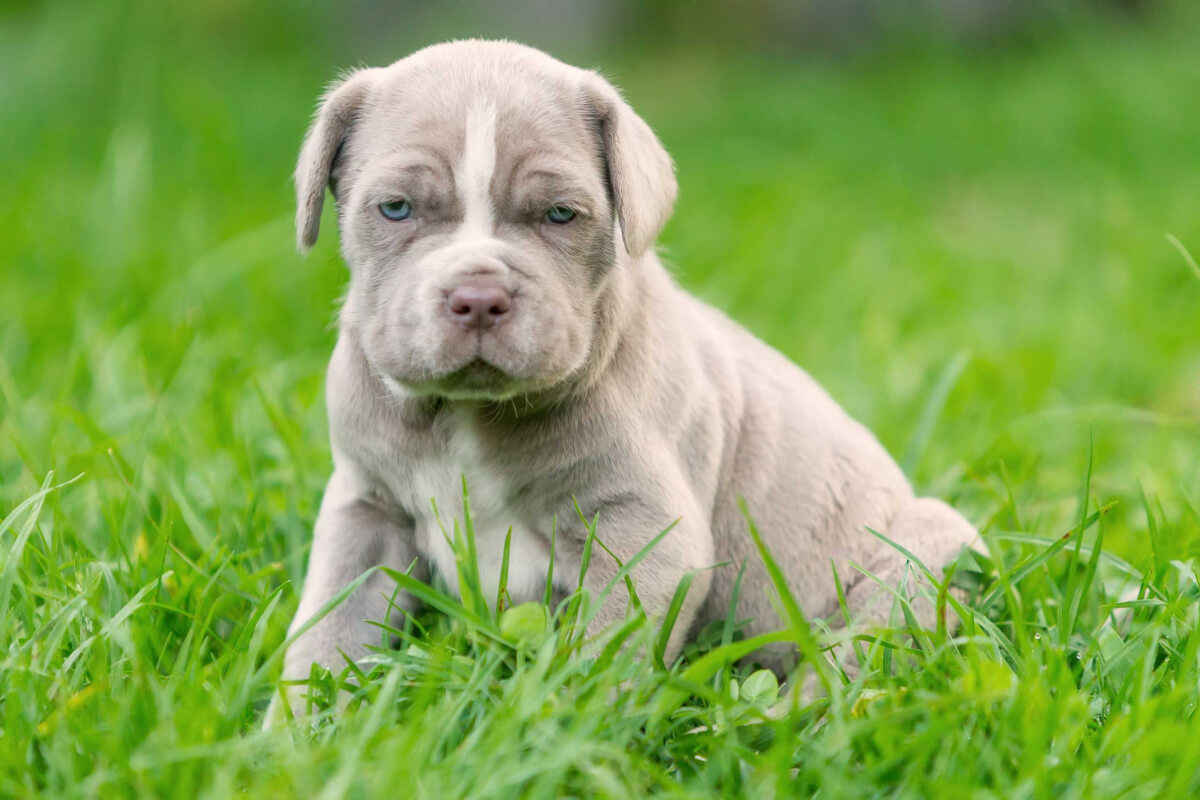


2. Bergamasco Sheepdogs — score 0.84
  - Energy (3/5) — matches your activity level 2
  - Trainability (3/5) — fits your time for training 5
  - Shedding: 1/5
  - Barking: 1/5
  - Playfulness: 3/5


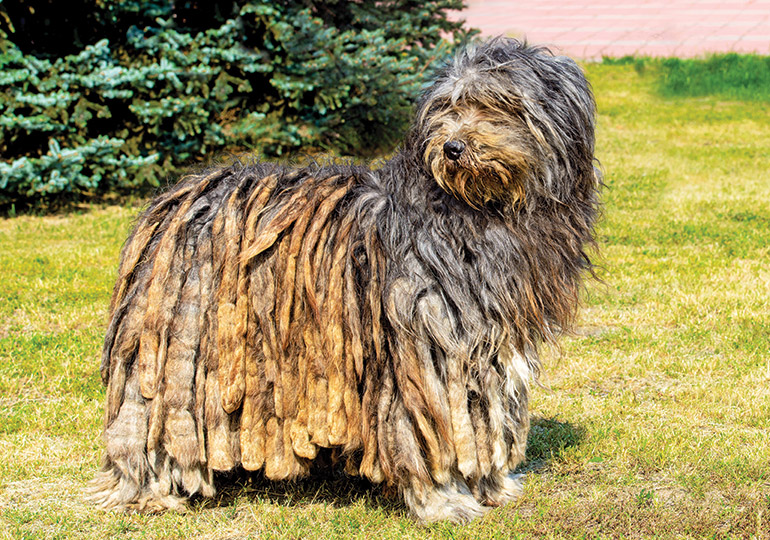


3. Spaniels (American Water) — score 0.83
  - Energy (3/5) — matches your activity level 2
  - Trainability (5/5) — fits your time for training 5
  - Shedding: 1/5
  - Barking: 3/5
  - Playfulness: 3/5


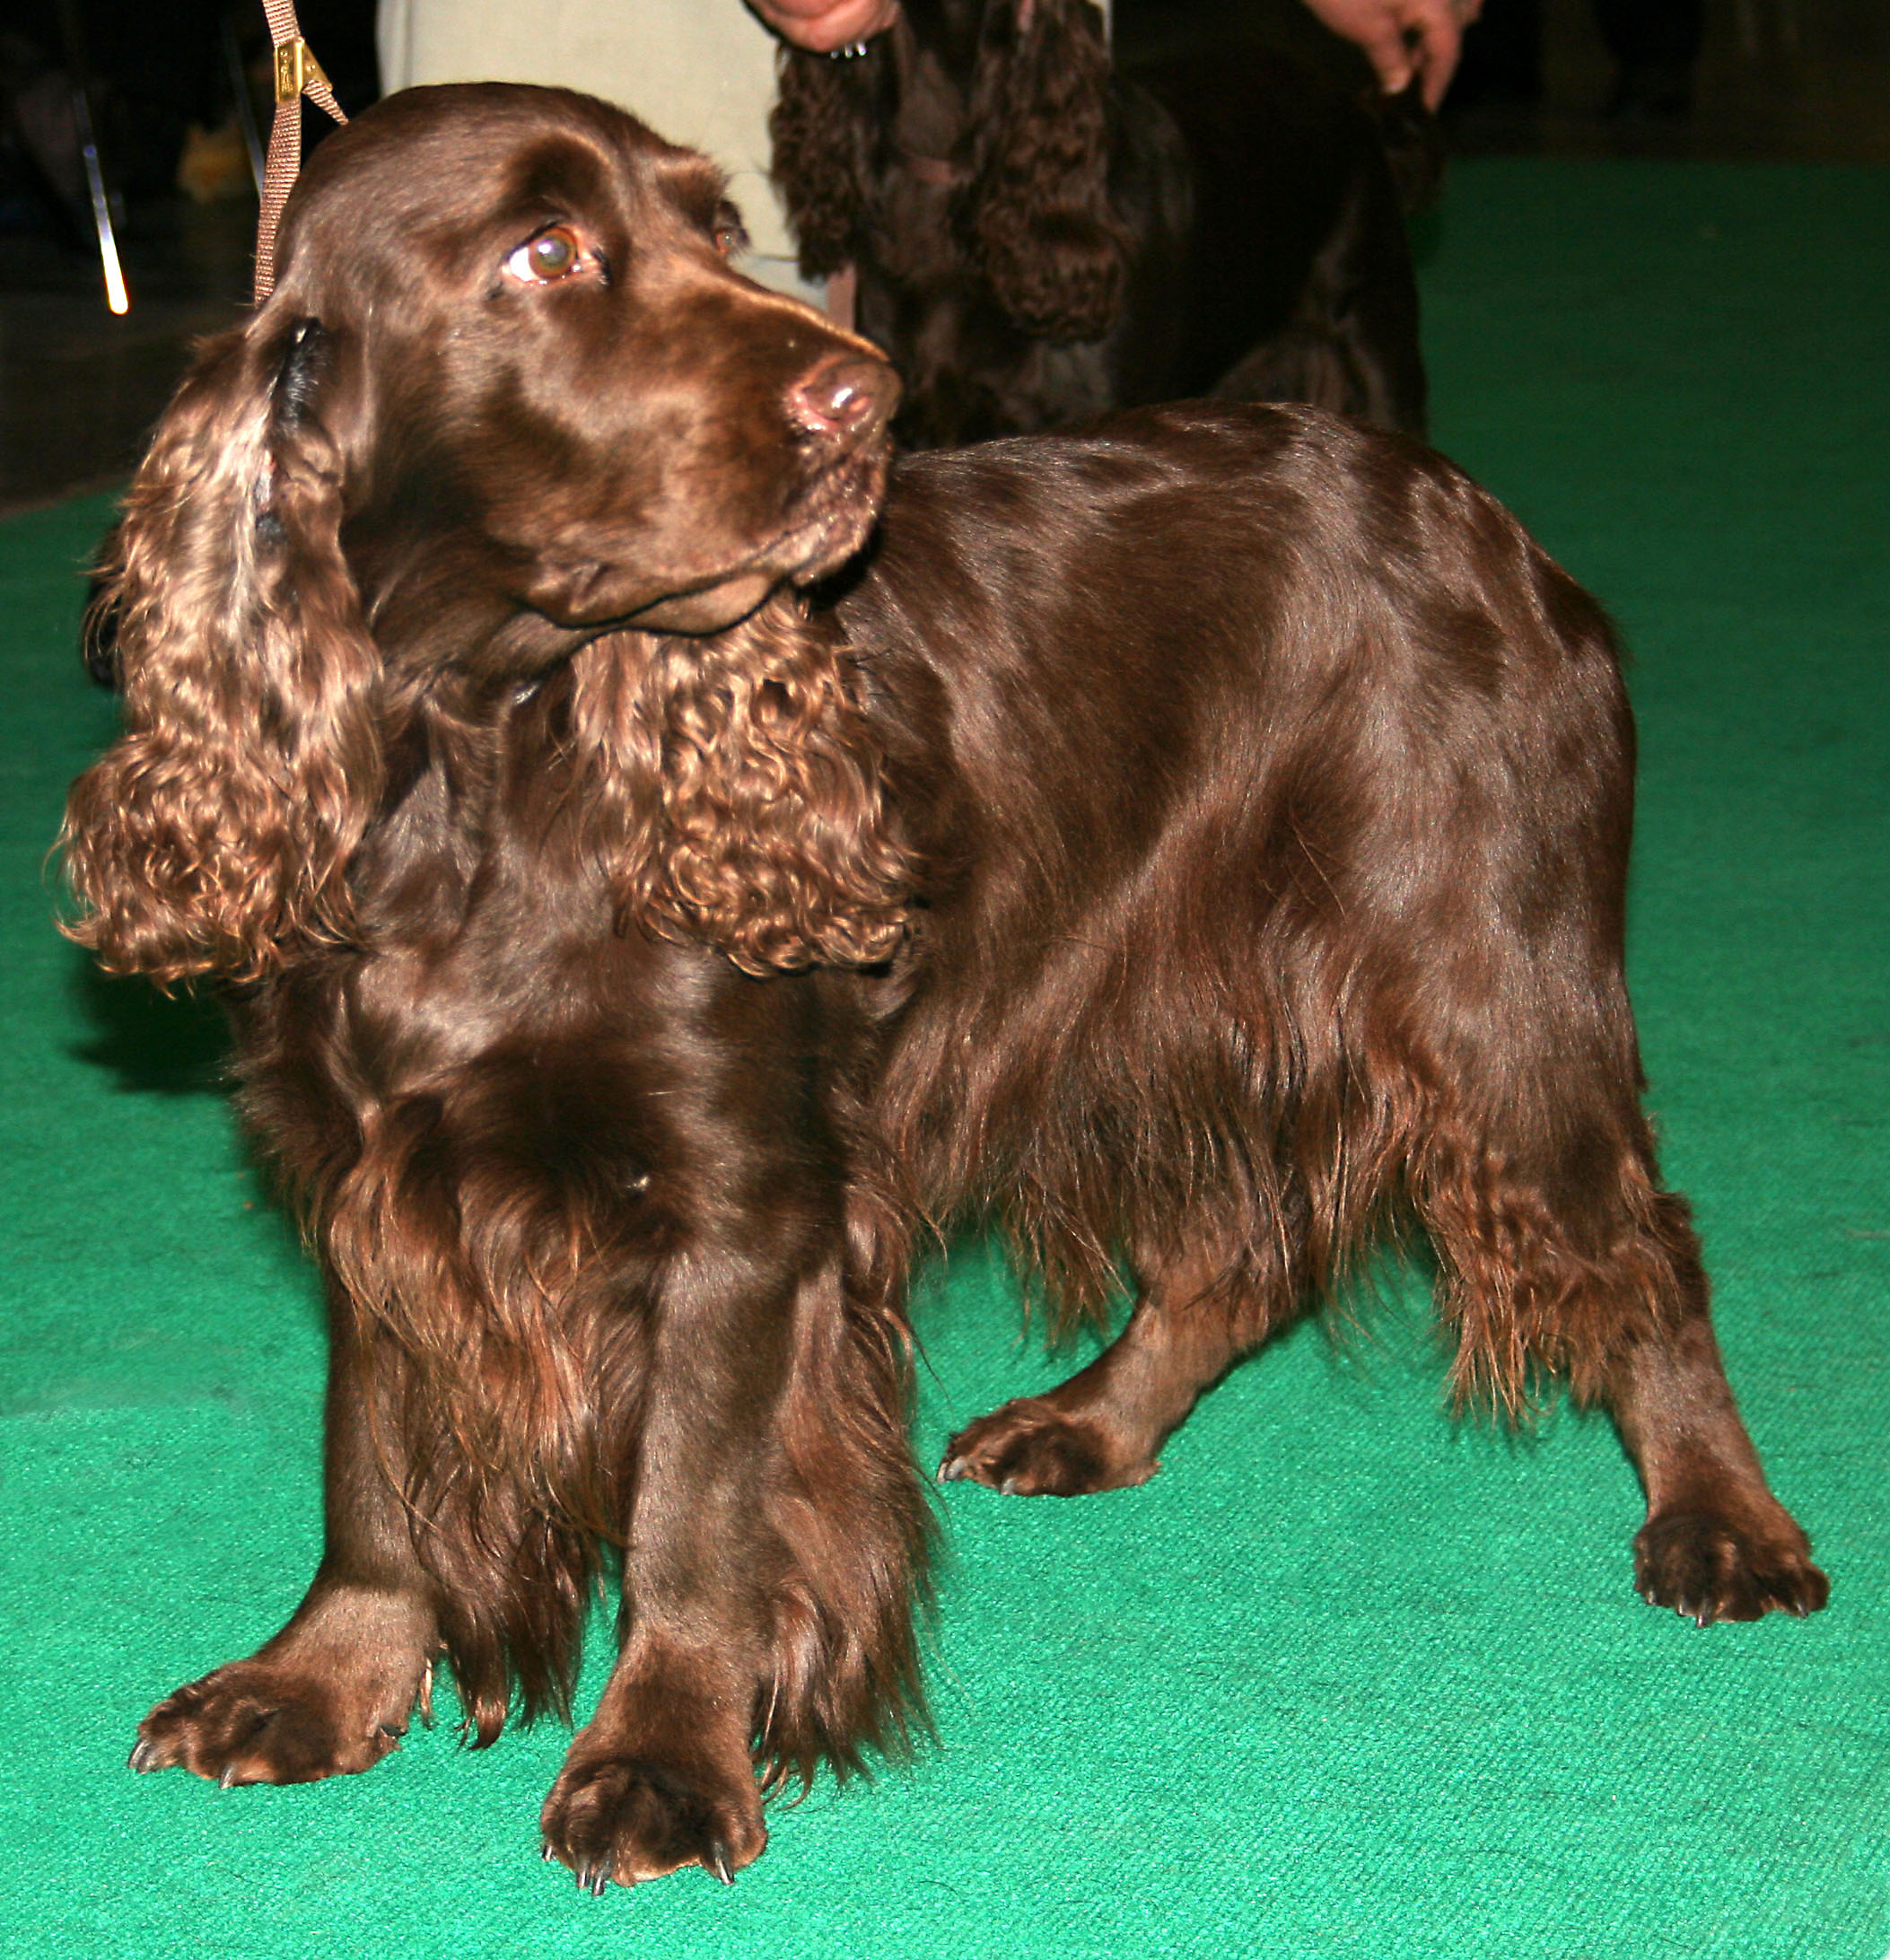

,breed,affection,good_with_kids,good_with_dogs,shedding,grooming,drooling,Coat Type,Coat Length,openness,playfulness,watchdog,adaptability,trainability,energy,barking,mental_needs,hypoallergenic,score
99,Neapolitan Mastiffs,3,3,3,3,2,5,Smooth,Short,3,2,5,3,3,2,1,3,False,0.861905
172,Bergamasco Sheepdogs,3,3,3,1,1,2,Corded,Long,3,3,4,3,3,3,1,3,True,0.836905
157,Spaniels (American Water),3,3,3,1,3,1,Double,Medium,3,3,3,3,5,3,3,3,True,0.832143


In [ ]:
import random

def notebook_chat_demo_mock(df):
    print("Hi — I'm your Dog Matchmaker (mock test mode).")
    print("Generating random user preferences...\n")
    
    # Basic Information
    activity = random.randint(1, 5)
    home = random.choice(['apartment', 'house'])
    children = random.choice([True, False])
    allergies = random.choice([True, False])
    time_train = random.randint(1, 5)
    size_pref = random.choice(['small', 'medium', 'large', None])
    other_dogs = random.choice([True, False])
    
    # Additional Preferences
    shedding_tolerance = random.randint(1, 5)
    grooming_tolerance = random.randint(1, 5)
    drooling_tolerance = random.randint(1, 5)
    barking_tolerance = random.randint(1, 5)
    playfulness_pref = random.randint(1, 5)
    affection_pref = random.randint(1, 5)
    openness_pref = random.randint(1, 5)
    mental_stimulation = random.randint(1, 5)
    
    # Make None equivalent to "no preference"
    if size_pref is None:
        size_pref_clean = None
    else:
        size_pref_clean = size_pref.lower()
    
    prefs = {
        'activity_level': activity,
        'home': home,
        'children': children,
        'allergies': allergies,
        'time_for_training': time_train,
        'size_pref': size_pref_clean,
        'shedding_tolerance': shedding_tolerance,
        'grooming_tolerance': grooming_tolerance,
        'drooling_tolerance': drooling_tolerance,
        'barking_tolerance': barking_tolerance,
        'playfulness_pref': playfulness_pref,
        'affection_pref': affection_pref,
        'other_dogs': other_dogs,
        'openness_pref': openness_pref,
        'mental_stimulation': mental_stimulation
    }
    
    # Print chosen random values
    print("Generated preferences:")
    print(f"  - Activity level: {activity}")
    print(f"  - Home: {home}")
    print(f"  - Children: {children}")
    print(f"  - Allergies: {allergies}")
    print(f"  - Time for training: {time_train}")
    print(f"  - Size preference: {size_pref_clean or 'no preference'}")
    print(f"  - Other dogs: {other_dogs}")
    print(f"  - Shedding tolerance: {shedding_tolerance}")
    print(f"  - Grooming tolerance: {grooming_tolerance}")
    print(f"  - Drooling tolerance: {drooling_tolerance}")
    print(f"  - Barking tolerance: {barking_tolerance}")
    print(f"  - Playfulness preference: {playfulness_pref}")
    print(f"  - Affection preference: {affection_pref}")
    print(f"  - Openness preference: {openness_pref}")
    print(f"  - Mental stimulation: {mental_stimulation}")
    
    results = top_k_matches(df, prefs, k=3)
    
    print("\nTop 3 matches:")
    for i, (_, row) in enumerate(results.iterrows(), start=1):
        print(f"\n{i}. {row['breed']} — score {row['score']:.2f}")
        for r in explain_match(row, prefs):
            print(f"  - {r}")
        
        # image preview if mapping present
        img_path = None
        if MAPPING_JSON.exists():
            mp = json.load(open(MAPPING_JSON, encoding='utf8'))
            folder = mp.get(row['breed'], normalize_for_folder(row['breed']))
            p = IMAGES_DIR / folder
            if p.exists():
                # Check for images with case-insensitive matching
                imgs = (sorted(p.glob('*.jpg')) + sorted(p.glob('*.jpeg')) + sorted(p.glob('*.png')) +
                       sorted(p.glob('*.JPG')) + sorted(p.glob('*.JPEG')) + sorted(p.glob('*.PNG')))
                if imgs:
                    img_path = imgs[0]
        else:
            # try direct normalized folder
            p = IMAGES_DIR / normalize_for_folder(row['breed'])
            if p.exists():
                imgs = (sorted(p.glob('*.jpg')) + sorted(p.glob('*.jpeg')) + sorted(p.glob('*.png')) +
                       sorted(p.glob('*.JPG')) + sorted(p.glob('*.JPEG')) + sorted(p.glob('*.PNG')))
                if imgs:
                    img_path = imgs[0]
        
        # display image inline
        if img_path:
            display(Image(filename=img_path, width=300))
    
    # Generate social media post for top match
    if len(results) > 0:
        print("\n" + "="*60)
        print("📱 SOCIAL MEDIA POST (Copy & Share!)")
        print("="*60)
        top_match = results.iloc[0]
        social_post = generate_social_post(top_match, prefs)
        print(social_post)
        print("="*60)
    
    return results

# Run mock demo
notebook_chat_demo_mock(breeds_df)



## 7 — Streamlit app (added to `app/app.py`)

Use this script to launch a lightweight chat-like UI. It uses the same matching code and mapping file for images.

Or see the hosted app: https://dogmatchmaker.streamlit.app/

In [ ]:
!streamlit run app/app.py